In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from learnMSA.msa_hmm import (Align, Clustering, Configuration, Initializers,
                              Visualize)
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset

2025-05-05 14:35:21.542780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-05 14:35:21.559207: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-05 14:35:21.564414: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Ungapped alignment

In [2]:
name = "2_200"
suffix = "_del"

# unaligned sequences
train_filename = f"../trees/data/dev_msa/{name}{suffix}.unaligned.fa"
# reference alignment of all sequences
ref_filename = f"../trees/data/dev_msa/{name}{suffix}.fa"
# tree used to generate the sequences
tree_filename = f"../trees/data/dev_trees/{name}.nwk"

# number of distinct pHMMs
num_models = 1

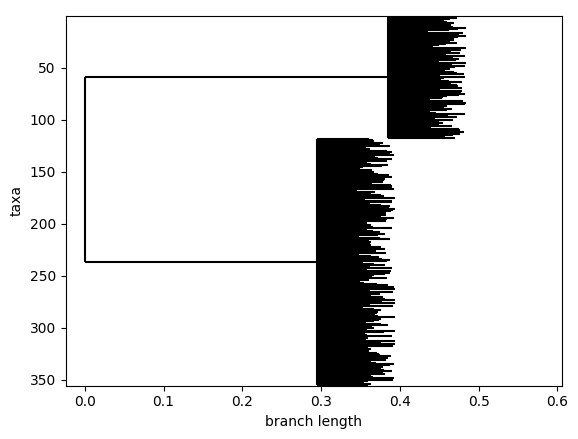

In [3]:
## Real tree used to generate the data
true_tree : Clustering.TreeHandler = Clustering.TreeHandler.read(tree_filename)
true_tree.draw(no_labels=True)

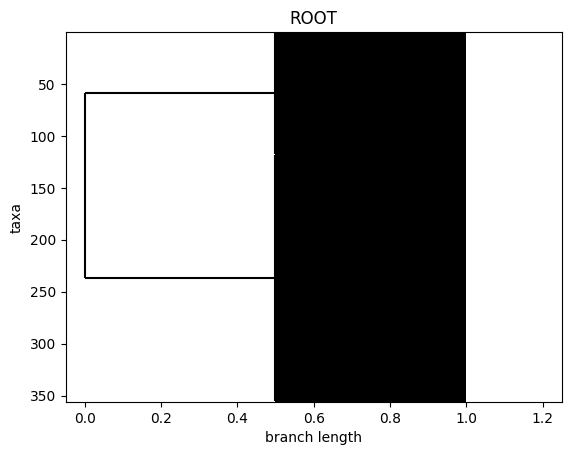

In [4]:
# compute a clustering from the unaligned sequences and a rough initial tree 
# with short branches
clustering : pd.DataFrame = Clustering.compute_clustering(
    train_filename, cluster_seq_id=0.8, linear=False
)
tree_handler = Clustering.cluster_tree(clustering, branch_length=0.5)
tree_handler.draw(no_labels=True)

Falsely clustered sequences can lead to poor alignments. We'll have to account for that.

Problem: How to do that without computing emissions and transitions w.r.t. all models?

In [5]:
# compute cluster precision
true_cluster_indices = true_tree.get_parent_indices_by_height(0)
cluster_indices = tree_handler.get_parent_indices_by_height(0)

true_positives = 0
positives = 0   
trues = 0   

leaf_names = tree_handler.node_names[:tree_handler.num_leaves]
for i,u_name in enumerate(leaf_names):
    for v_name in leaf_names[i+1:]:
        u = tree_handler.nodes[u_name]
        v = tree_handler.nodes[v_name]
        tu = true_tree.nodes[u_name]
        tv = true_tree.nodes[v_name]
        positives += int(u.parent == v.parent)
        trues += int(tu.parent == tv.parent)
        true_positives += int(u.parent == v.parent and tu.parent == tv.parent)

print("Cluster precision:", true_positives/positives)
print("Cluster recall:", true_positives/trues)
print("True number of clusters: ", true_tree.num_anc-1)
print("Predicted number of clusters: ", tree_handler.num_anc-1)

Cluster precision: 1.0
Cluster recall: 1.0
True number of clusters:  2
Predicted number of clusters:  2


Warmup of 1 models.
Fitting models of lengths [90] on 355 sequences.
Batch size= 178 Learning rate= 0.1
Don't use sequence weights.
Using 1 GPUs.
Epoch 1/3
10/10 - 8s - 844ms/step - loss: 353.2381 - loglik: -2.4134e+02 - prior: -1.1190e+02 - aux_loss: 0.0000e+00
Epoch 2/3
10/10 - 1s - 116ms/step - loss: 183.2513 - loglik: -1.5911e+02 - prior: -2.4138e+01 - aux_loss: 0.0000e+00
Epoch 3/3
10/10 - 1s - 117ms/step - loss: 112.5251 - loglik: -1.0515e+02 - prior: -7.3786e+00 - aux_loss: 0.0000e+00
Fitted model successfully.
Creating alignment model...
Successfully created alignment model.
Training of 1 models on file 2_200_del.unaligned.fa
Configuration: 
{
num_models : 1
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : Const(shape=(90,)) , match_to_end : Const(shape=(90,)) , 
    match_to_match : Const(shape=(89,)) , match_to_insert : Const(shape=(89,)) , 
    insert_to_match : Const(shape=(89,)) , insert_to_insert : Const(shape=(89,)) , 
    match_to_dele

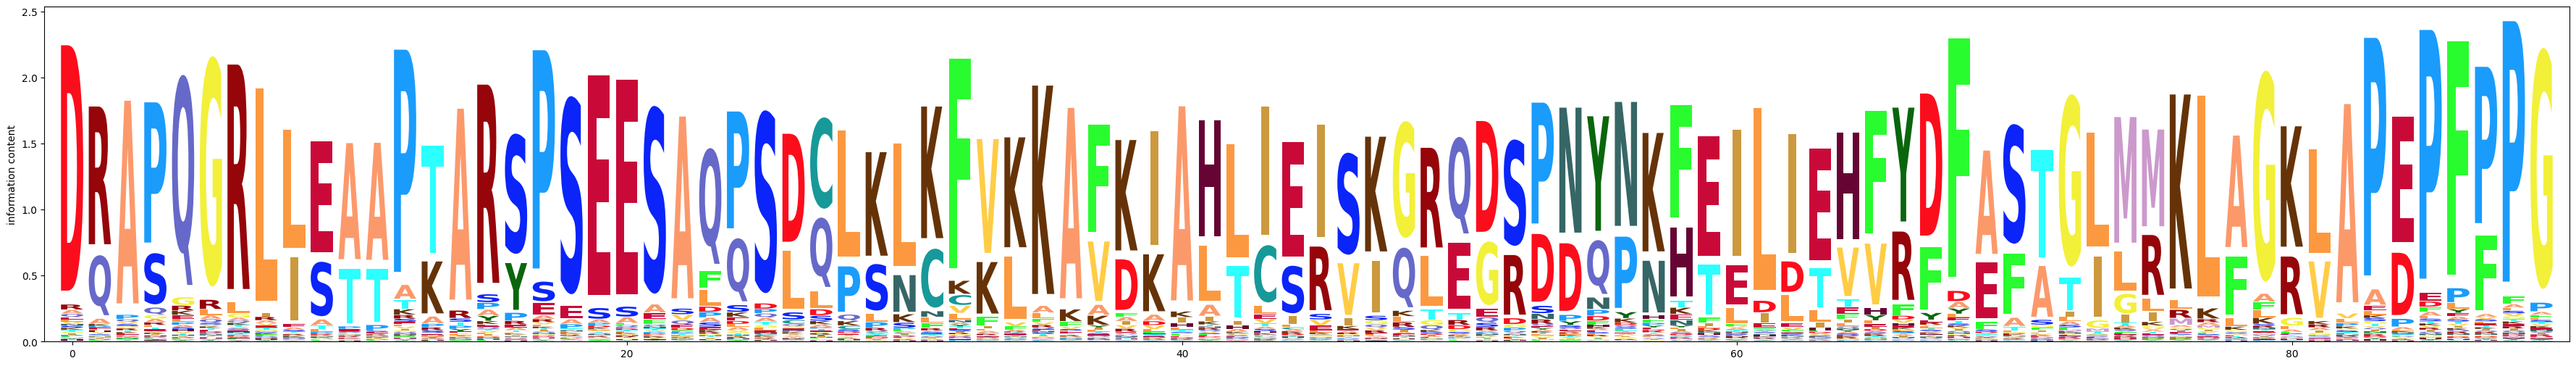

In [6]:
use_tree_transitioner = False
warmup_epochs = 3
perturbation_prob_min=0.0
perturbation_prob_init=0.0
perturbation_prob_decay=0.0


out_filename = "test/data/single_del_propagate_root.fasta"
with SequenceDataset(train_filename, fmt="fasta") as data:

    if warmup_epochs > 0:
        # warmup without tree 
        # this quickly learns an initial profile
        warmup_config = Configuration.make_default(num_models)
        # short initial model, focus on important sites
        warmup_config["len_mul"] = 1.0
        warmup_config["length_init_quantile"] = 0.5 # chose among the longer seqs
        # no surgery, only a few epochs of warmup
        warmup_config["max_surgery_runs"] = 1
        warmup_config["epochs"][0] = warmup_epochs

        print("Warmup of", warmup_config["num_models"], "models.")

        emission_kernel_dummy = warmup_config["emitter"].emission_init[0]
        transition_kernel_dummy = warmup_config["transitioner"].transition_init[0]
        flank_init_kernel_dummy = warmup_config["transitioner"].flank_init[0]

        initial_model_length_callback = partial(
            Align.get_initial_model_lengths, random=False
        )

        warmup_alignment_model = Align.fit_and_align(
            data, 
            warmup_config,
            initial_model_length_callback=initial_model_length_callback
        )
        warmup_emitter = warmup_alignment_model.msa_hmm_layer.cell.emitter[0]
        warmup_transitioner = warmup_alignment_model.msa_hmm_layer.cell.transitioner

        _, ax = plt.subplots(1, 1, figsize=(10, 5))
        Visualize.plot_logo(warmup_alignment_model, 0, ax)

        config = Configuration.make_default(
            num_models, 
            tree_handler=tree_handler,
            tree_loss_weight=1.0,
            use_tree_transitioner=use_tree_transitioner,
            perturbation_prob_min=perturbation_prob_min,
            perturbation_prob_init=perturbation_prob_init,
            perturbation_prob_decay=perturbation_prob_decay,
            propagate_root=False
        )

        # initialize with the warmup parameters
        config["emitter"].emission_init = []
        config["emitter"].insertion_init = []
        config["transitioner"].transition_init = []
        config["transitioner"].flank_init = []
        for i in range(num_models):
            config["emitter"].emission_init.append(
                Initializers.ConstantInitializer(
                    warmup_emitter.emission_kernel[i].numpy()[np.newaxis,:,:]
                )
            )
            config["emitter"].insertion_init.append(
                Initializers.ConstantInitializer(
                    warmup_emitter.insertion_kernel[i].numpy()[np.newaxis,:]
                )
            )
            trans_dict = {}
            config["transitioner"].transition_init.append(trans_dict)
            for key in warmup_transitioner.transition_kernel[0].keys():
                K = warmup_transitioner.transition_kernel[i][key].numpy()
                if use_tree_transitioner:
                    K = K[np.newaxis,:]
                trans_dict[key] = Initializers.ConstantInitializer(K)
            F = warmup_transitioner.flank_init_kernel[i].numpy()
            if use_tree_transitioner:
                F = F[np.newaxis,:]
            config["transitioner"].flank_init.append(
                Initializers.ConstantInitializer(F)
            )

        config["emission_kernel_dummy"] = emission_kernel_dummy
        config["transition_kernel_dummy"] = transition_kernel_dummy
        config["flank_init_kernel_dummy"] = flank_init_kernel_dummy

        initial_model_length_callback = lambda data, config : warmup_emitter.lengths
    else:
        config = Configuration.make_default(
            num_models, 
            tree_handler=tree_handler,
            tree_loss_weight=1.,
            use_tree_transitioner=use_tree_transitioner,
            perturbation_prob_min=perturbation_prob_min,
            perturbation_prob_init=perturbation_prob_init,
            perturbation_prob_decay=perturbation_prob_decay,
            propagate_root=False
        )
        config["len_mul"] = 1.0
        config["length_init_quantile"] = 0.5 # chose among the longer seqs
        initial_model_length_callback = partial(
            Align.get_initial_model_lengths, random=False
        )

    config["max_surgery_runs"] = 1
    config["epochs"][0] = 25
    #config["model_criterion"] = "loglik_with_tree"

    alignment_model = Align.run_learnMSA(
        data,
        out_filename,
        config, 
        verbose=True,
        align_insertions=True,
        initial_model_length_callback=initial_model_length_callback
    )

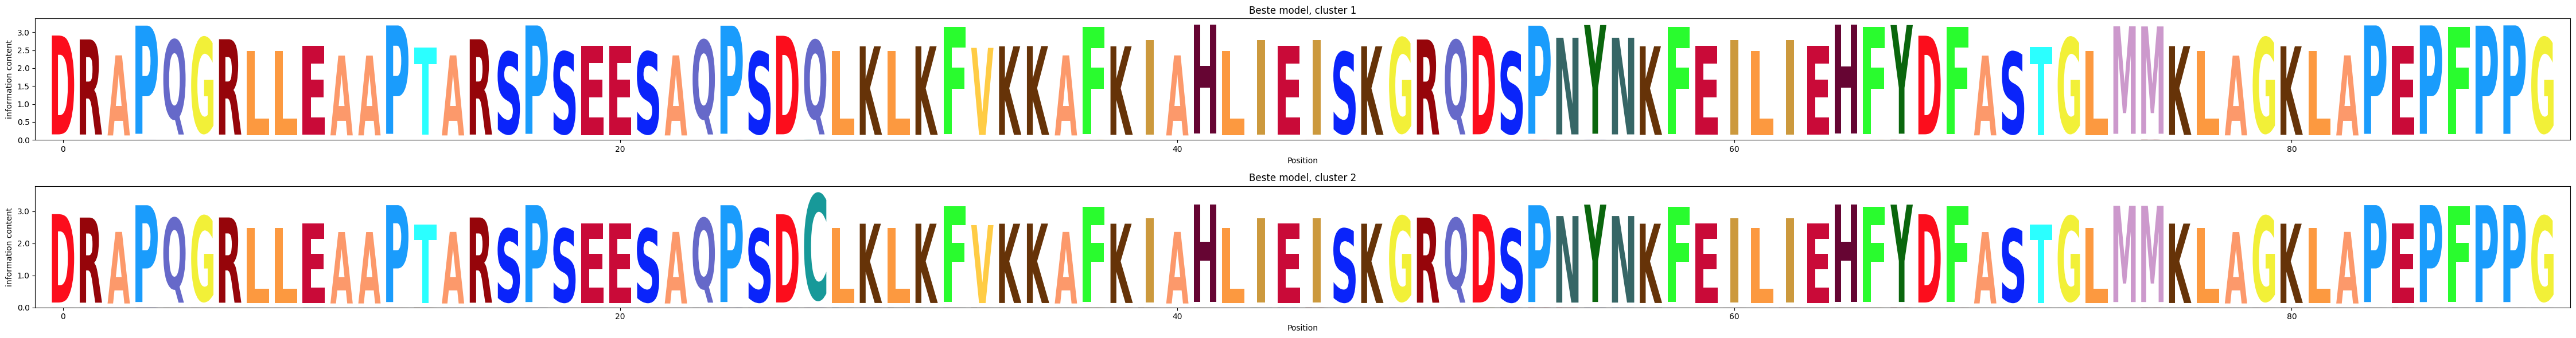

In [7]:
num_clust = tree_handler.num_anc-1
fig, axes = plt.subplots(num_clust, 1, figsize=(10, 5))
for i in range(num_clust):
    ax = axes[i]
    ax.set_title(f"Beste model, cluster {i+1}")
    ax.set_xlabel("Position")
    ax.set_ylabel("Information content")
    Visualize.plot_logo(
        alignment_model, alignment_model.best_model, ax, cluster_index=i
    )
plt.tight_layout()

In [8]:
!grep ">leaf117" -A 10 -B 10 test/data/single_del_propagate_root.fasta

TIGILRKLFGRVSPDPIMPG
>leaf114
DQASQSRLIATTPTYRYPYEESAfvdkeglqslQPENCFKLKAVNKTLTCSRVIQLVEGRDDQPNHTDLDLTVVRFFEFA
TIGILRKLFAKVAPDPFFPG
>leaf115
DQASQGRLISTTPKSRYPSEESAfldkeglnslQPSDCFKLKRVDKALTCNRVLQLTEGRDDQPKHKELDLTVVRFFEFA
TIWILRKLFGKVAPDPFFPG
>leaf116
DQASQGRLISTTPKSRYPSEESAfvdkeglqslQPSNCFKLKAVDKALTCSRVVQLTEGRDDQPNHTILDLTVVRFFEFA
TIGILRKLFGRVAPDPFIPG
>leaf117
DRAPQGRLLEAAPTARSPSEESA..........QPSDCLKLKFVKRAFKIAHLIEISKGRQDSPQYNKFEILIQQFYDFA
STGLMMKLAGKLAPEPFPPG
>leaf118
DRAPQARLLEAAPTARSPSEESA..........RPSDCLKLKFVKKAFKIAHLIEISKGRQDSPNYNKFEVLIEHFYDFA
STGMMMKLAGKLAPEPFPPG
>leaf119
DRAPKGRMLEAAPTARSPSEESA..........QNSDCLKLKFVKKAFKIAHLIEISKGRQDSPNYNKFELLIEHLYDFA
STGLMMKLVGKLAPEPFPPG
>leaf120
DRAPQGRLLEAAPTARTPSEELA..........QPSDCLKLKFVKKAFKIAHLIEVSKGKEDSPNYNKFEILIEQFYDFA


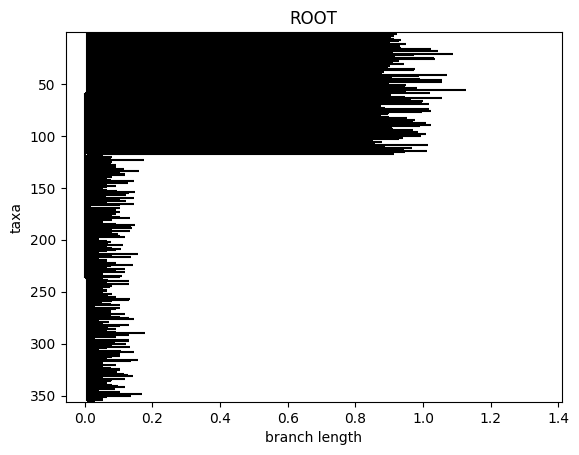

In [9]:
# plot the tree after training
# this requires to get both the branch lengths of the tree emitter for the 
# ancestral past of the tree as well as the lengths of all leaf branches from 
# the ancestral probability layer

# ancestral part
tree_emitter = alignment_model.msa_hmm_layer.cell.emitter[0]
branch_lengths = tree_emitter.get_branch_lengths().numpy()
branch_lengths = branch_lengths[:, alignment_model.best_model]
branch_lengths = branch_lengths[:, np.newaxis]

# leaf part
anc_prob_layer = alignment_model.encoder_model.layers[-3]
leaf_branch_lengths = anc_prob_layer.make_times().numpy()
leaf_branch_lengths = leaf_branch_lengths[:,alignment_model.best_model]
leaf_branch_lengths = leaf_branch_lengths[:,np.newaxis]

branch_lengths = np.concatenate((leaf_branch_lengths, branch_lengths), axis=0)

tree_emitter.tree_handler.set_branch_lengths(branch_lengths)
tree_emitter.tree_handler.draw(no_labels=True)